<a href="https://colab.research.google.com/github/williamedwardhahn/ComplexSystems/blob/main/Complex_Systems_Lab_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/williamedwardhahn/mpcr
from mpcr import *

  Cloning https://github.com/williamedwardhahn/mpcr to /tmp/pip-req-build-mze6lgvo
  Running command git clone -q https://github.com/williamedwardhahn/mpcr /tmp/pip-req-build-mze6lgvo
  Created wheel for ImportMPCR: filename=ImportMPCR-0.0.1-cp36-none-any.whl size=7325 sha256=35cce23b7eaf5b8f6fecbb504bb1aee108b824de78db2f2de9075e61a6cdd656
  Stored in directory: /tmp/pip-ephem-wheel-cache-m8t7ccbv/wheels/89/93/47/ef43fe80a5b823a05d8dcca5ed1581f4fcdacf69b27110603f
Successfully built ImportMPCR
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils

In [ ]:
def Encoder(x,w):
    x = relu(conv2d(x,w[0], stride=(2, 2), padding=(1, 1)))
    x = relu(conv2d(x,w[1], stride=(2, 2), padding=(1, 1)))
    x = x.view(x.size(0), 6272)
    x = linear(x,w[2])
    return x

In [ ]:
def Decoder(x,w):
    x = linear(x,w[3])
    x = x.view(x.size(0), 128, 7, 7)
    x = relu(conv_transpose2d(x,w[4], stride=(2, 2), padding=(1, 1)))
    x = torch.tanh(conv_transpose2d(x,w[5], stride=(2, 2), padding=(1, 1)))
    return x

In [ ]:
def Autoencoder(x,w):
    return Decoder(Encoder(x,w),w)

In [ ]:
def randn_trunc(s): #Truncated Normal Random Numbers
    mu = 0 
    sigma = 0.1
    R = stats.truncnorm((-2*sigma - mu) / sigma, (2*sigma - mu) / sigma, loc=mu, scale=sigma)
    return R.rvs(s)

In [ ]:
def GPU(data):
    return torch.tensor(data, requires_grad=True, dtype=torch.float, device=torch.device('cuda'))

In [ ]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

In [ ]:
def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [ ]:
def plot(x):
    if type(x) == torch.Tensor :
        x = x.cpu().detach().numpy()

    fig, ax = plt.subplots()
    im = ax.imshow(x, cmap = 'gray')
    ax.axis('off')
    fig.set_size_inches(10, 10)
    plt.show()

In [ ]:
num_epochs = 10
batch_size = 512
learning_rate = 1e-3

In [ ]:
img_transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw


Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw


Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def MSE(image_batch_recon, image_batch):
    return torch.mean((image_batch_recon - image_batch)**2)

In [ ]:
#Encode
w0 = GPU(randn_trunc((64,1,4,4)))
w1 = GPU(randn_trunc((128,64,4,4)))
w2 = GPU(randn_trunc((10,6272)))
#Decode
w3 = GPU(randn_trunc((6272,10)))
w4 = GPU(randn_trunc((128,64,4,4)))
w5 = GPU(randn_trunc((64,1,4,4)))

w = [w0,w1,w2,w3,w4,w5]

optimizer = torch.optim.Adam(params=w, lr=learning_rate, weight_decay=1e-5)

for epoch in range(num_epochs):

    for image_batch, _ in train_dataloader:
        
        image_batch = image_batch.to(device)
        
        # autoencoder reconstruction
        image_batch_recon = Autoencoder(image_batch,w)
        
        # reconstruction error
        loss = MSE(image_batch_recon, image_batch)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 
    print(loss.item())



0.15035611391067505
0.12154980003833771
0.11118477582931519
0.08765213936567307
0.08735077828168869
0.07676716148853302
0.07329043745994568
0.08160649985074997
0.07632128894329071
0.07401438057422638


In [ ]:
test_loss_avg, num_batches = 0, 0
for image_batch, _ in test_dataloader:    
    with torch.no_grad():
        image_batch = image_batch.to(device)
        image_batch_recon = Autoencoder(image_batch,w)
        loss = F.mse_loss(image_batch_recon, image_batch)
        test_loss_avg += loss.item()
        num_batches += 1
test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

average reconstruction error: 0.071857


In [ ]:
images, labels = iter(test_dataloader).next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


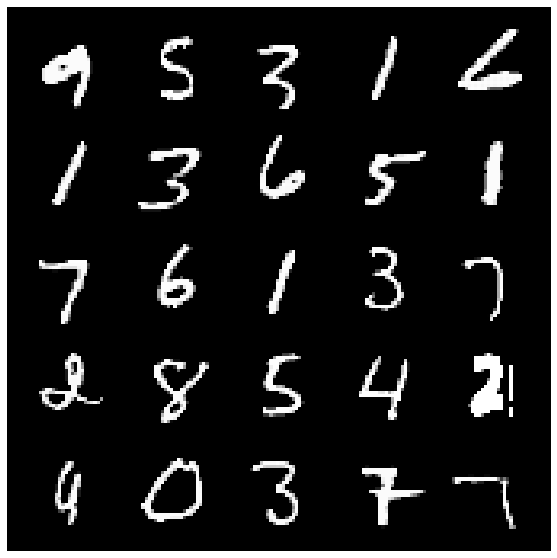

In [ ]:
plot(np.transpose(torchvision.utils.make_grid(images[:25], 5, 5).detach().numpy(), (1, 2, 0)))

In [ ]:
images = images.to(device)
images = Autoencoder(images,w)
images = images.cpu()
images = to_img(images)

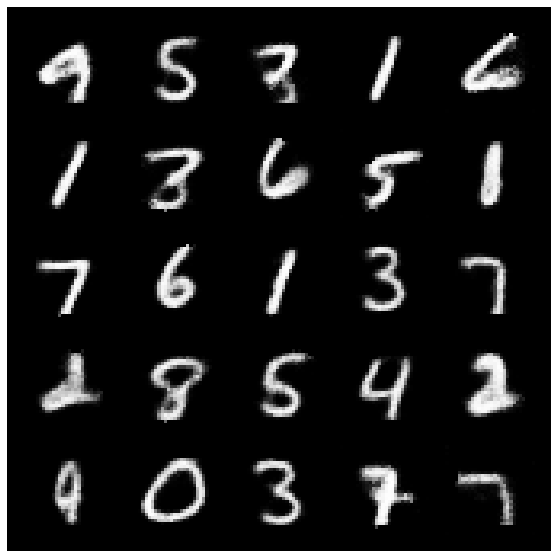

In [ ]:
plot(np.transpose(torchvision.utils.make_grid(images[:25], 5, 5).detach().numpy(), (1, 2, 0)))

In [ ]:
images = images.to(device)
code = Encoder(images,w).detach().cpu().numpy()

In [ ]:
code.shape

(512, 10)

In [ ]:
code

array([[-2.6420746 ,  2.6218486 , -0.24669087, ..., -1.7004849 ,
         1.7003448 , -8.393875  ],
       [ 1.1205838 ,  1.5369234 , -0.23460954, ..., -2.866073  ,
         0.4585305 , -3.3673055 ],
       [-1.5012426 ,  1.071016  , -1.8388616 , ...,  0.70709085,
        -0.48377526, -3.520955  ],
       ...,
       [-2.0968995 , -0.02568853, -1.8947092 , ..., -0.6978874 ,
         3.013755  , -3.445029  ],
       [-0.8278687 ,  0.3856804 , -1.4685142 , ...,  1.5695586 ,
         1.1716125 , -1.5597553 ],
       [-0.11916304,  0.55135345, -0.2152192 , ...,  2.520472  ,
        -1.5769186 , -3.6159258 ]], dtype=float32)

(array([  36.,  151.,  661., 1368., 1765.,  590.,  338.,  164.,   44.,
           3.]), array([-10.08305   ,  -7.7629642 ,  -5.442879  ,  -3.1227937 ,
         -0.80270845,   1.5173769 ,   3.8374622 ,   6.1575475 ,
          8.4776325 ,  10.797718  ,  13.117804  ], dtype=float32), <a list of 10 Patch objects>)

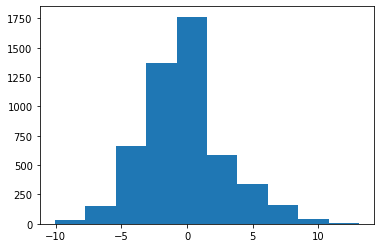

In [ ]:
plt.hist(code.flatten())

In [ ]:
def Make_Integer(x,count):

    start = np.min(x)
    stop = np.max(x)
    bins = np.linspace(start, stop, count-1)
    x = np.digitize(x, bins)
    
    return x

In [ ]:
Make_Integer(code,10)

array([[3, 5, 4, ..., 3, 5, 1],
       [4, 5, 4, ..., 3, 4, 3],
       [3, 4, 3, ..., 4, 4, 3],
       ...,
       [3, 4, 3, ..., 4, 5, 3],
       [4, 4, 3, ..., 5, 4, 3],
       [4, 4, 4, ..., 5, 3, 3]])

In [ ]:
plt.hist(Make_Integer(code,10).flatten(),100)

In [ ]:
x = Make_Integer(code,10)

In [ ]:
x.shape

(512, 10)

#Embed

In [ ]:
images = images.to(device)
code = Encoder(images,w).detach().cpu().numpy()

In [ ]:
code.shape

(512, 10)

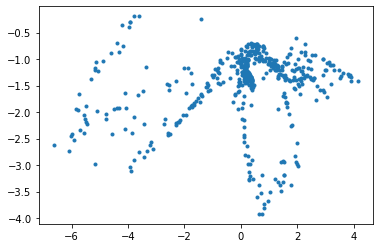

In [ ]:
plt.plot(code[:,0],code[:,1],'.')

In [ ]:
images, labels = iter(test_dataloader).next()

In [ ]:
x = images
y = labels

In [ ]:
j = 0

In [ ]:
k = [torch.where(y == j)[0].cpu().numpy() for j in range(10)]

In [ ]:
x[k[0]].shape

torch.Size([52, 1, 28, 28])

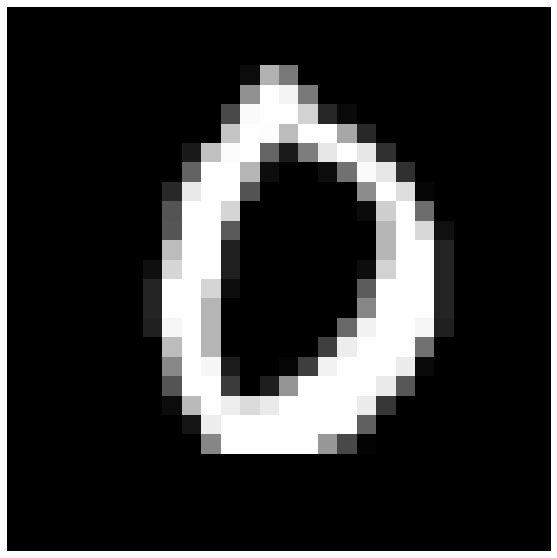

In [ ]:
plot(x[k[0][0],0,:,:].cpu().numpy())

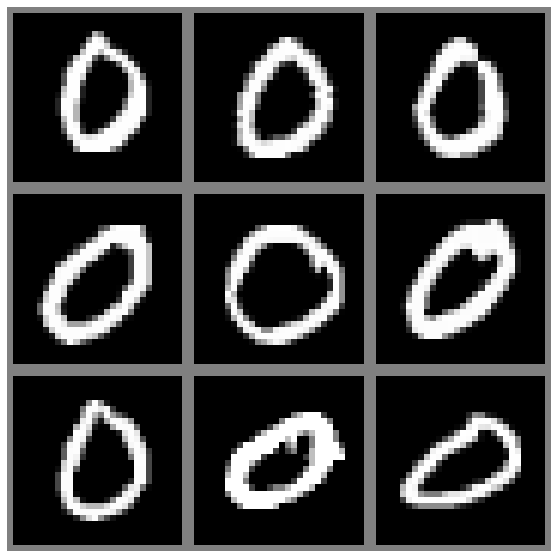

In [ ]:
montage_plot(x[k[0][0:9],0,:,:].cpu().numpy())

In [ ]:
def plot(x):
    if type(x) == torch.Tensor :
        x = x.cpu().detach().numpy()

    fig, ax = plt.subplots()
    im = ax.imshow(x, cmap = 'gray')
    ax.axis('off')
    fig.set_size_inches(10, 10)
    plt.show()

In [ ]:
def montage_plot(x):
    x = np.pad(x, pad_width=((0, 0), (1, 1), (1, 1)), mode='constant', constant_values=0)
    plot(montage(x))

In [ ]:
x0 = x[k[0][0:],:,:,:].to(device)
x1 = x[k[1][0:],:,:,:].to(device)
x2 = x[k[2][0:],:,:,:].to(device)
x3 = x[k[3][0:],:,:,:].to(device)

In [ ]:
x0.shape

torch.Size([52, 1, 28, 28])

In [ ]:
code0 = Encoder(x0,w).detach().cpu().numpy()
code1 = Encoder(x1,w).detach().cpu().numpy()
code2 = Encoder(x2,w).detach().cpu().numpy()
code3 = Encoder(x3,w).detach().cpu().numpy()

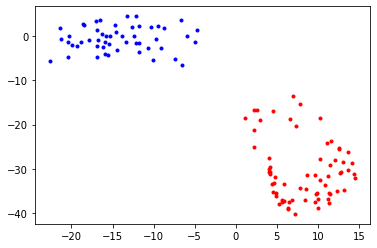

In [ ]:
plt.plot(code0[:,0],code0[:,1],'b.')
plt.plot(code1[:,0],code1[:,1],'r.')
# plt.plot(code2[:,0],code2[:,1],'g.')
# plt.plot(code3[:,0],code3[:,1],'m.')